<a href="https://colab.research.google.com/github/guvenim/colab/blob/master/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Darts for Timeseries Analysis

[Darts Homepage](https://unit8co.github.io/darts/quickstart/00-quickstart.html)

In [11]:
# To install darts and dask run the code below|
# !pip install darts
# !pip install dask[dataframe]

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

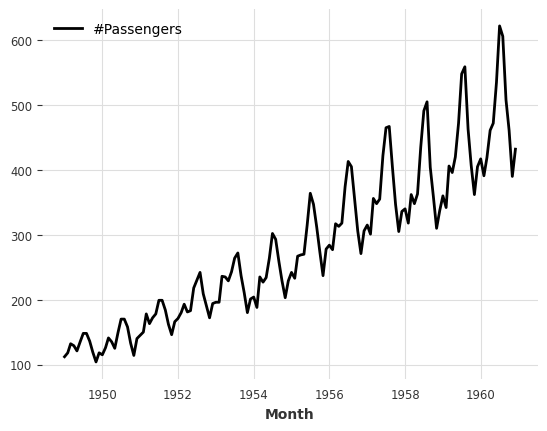

In [5]:
series = AirPassengersDataset().load()
series.plot();

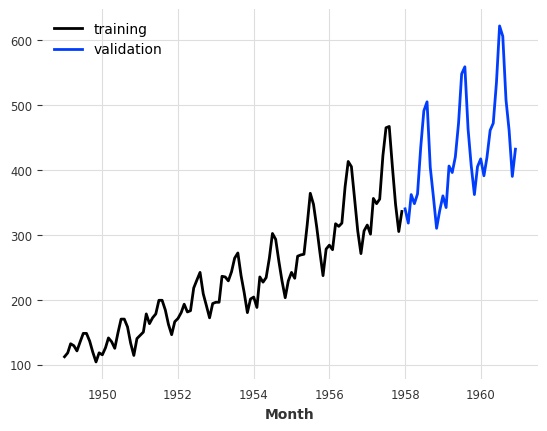

In [8]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation");

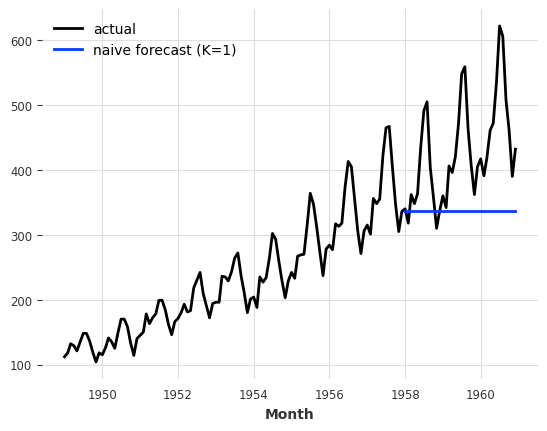

In [19]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)");

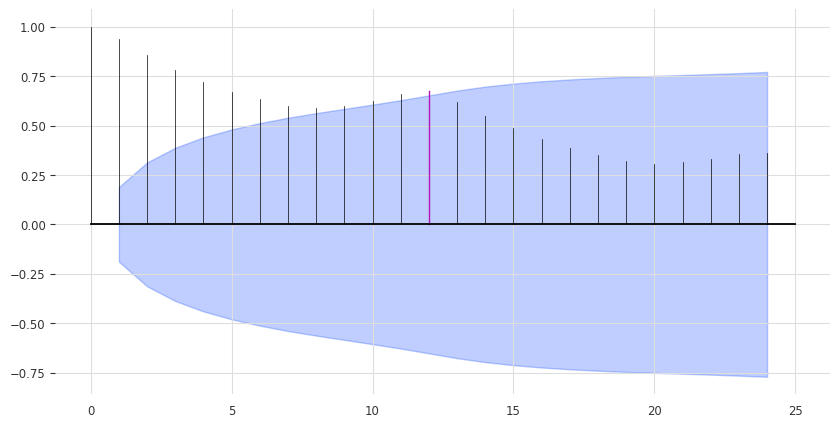

In [15]:
from darts.utils.statistics import check_seasonality, plot_acf
plot_acf(train, m=12, alpha=0.05, max_lag=24)

In [16]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print(f"There is seasonality of order {period}.")

There is seasonality of order 12.


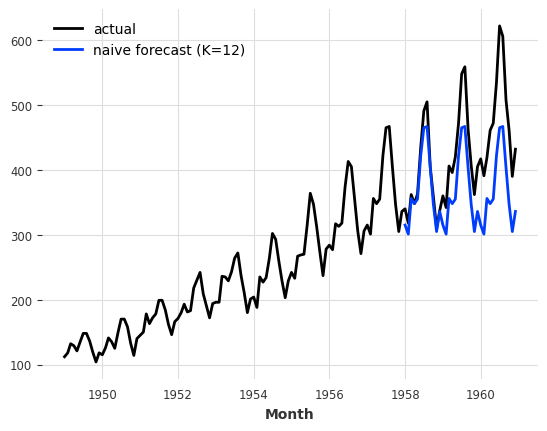

In [20]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)");

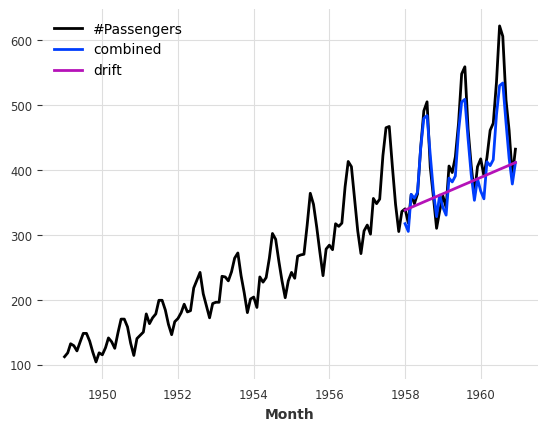

In [23]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift");

In [24]:
from darts.metrics import mape
from darts.metrics import rmse
print(f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%.")
print(f"Root Mean Squared Error for the combined naive drift + seasonal: {rmse(series, combined_forecast):.2f}.")

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [26]:
from darts.models import TBATS, AutoARIMA, ExponentialSmoothing, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


In [27]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [28]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(f"Lowest MAPE is: {mape(val, pred_best_theta):.2f}, with theta = {best_theta}.")

Lowest MAPE is: 4.40, with theta = -3.5102040816326543.


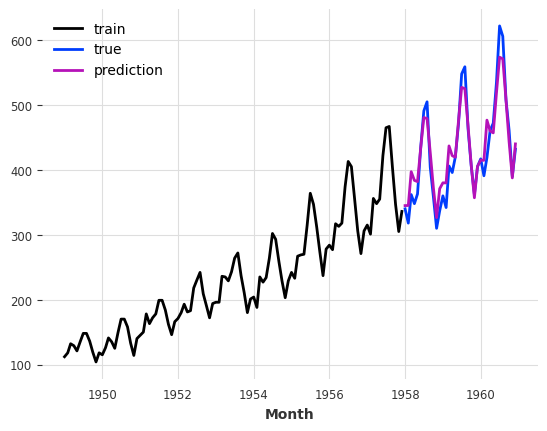

In [35]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction");

historical forecasts: 100%|██████████| 58/58 [00:01<00:00, 46.21it/s]


MAPE = 7.99%
CPU times: user 1.28 s, sys: 24.6 ms, total: 1.31 s
Wall time: 1.31 s


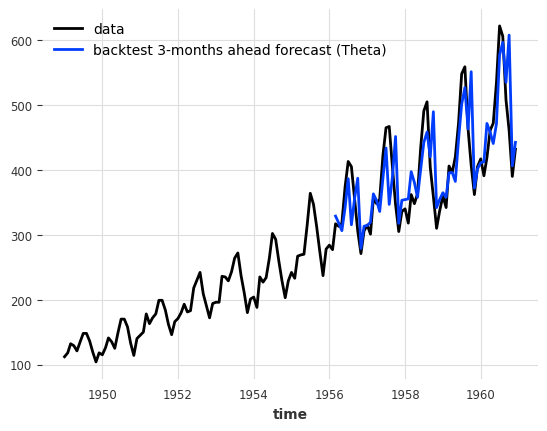

In [36]:
%%time

hfc_params = {
    "series": series,
    "start": pd.Timestamp(
        "1956-01-01"
    ),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}
historical_fcast_theta = best_theta_model.historical_forecasts(
    last_points_only=True, **hfc_params
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print(f"MAPE = {mape(series, historical_fcast_theta):.2f}%")

historical forecasts: 100%|██████████| 20/20 [00:00<00:00, 30.66it/s]


MAPE = 5.61%


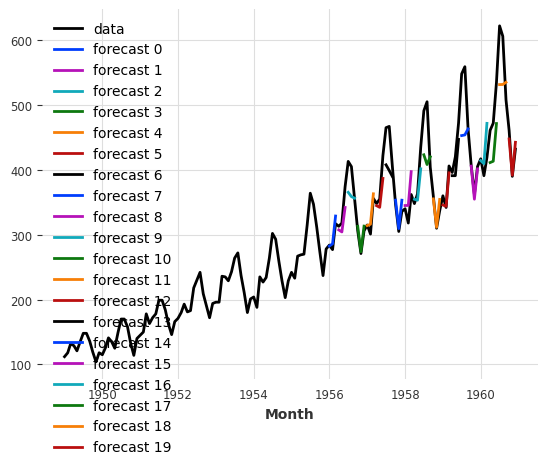

In [37]:
historical_fcast_theta_all = best_theta_model.historical_forecasts(
    last_points_only=False, stride=3, **hfc_params
)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_theta_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate

historical_fcast_theta_all = concatenate(historical_fcast_theta_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_theta_all):.2f}%")

historical forecasts: 100%|██████████| 58/58 [00:01<00:00, 47.58it/s]


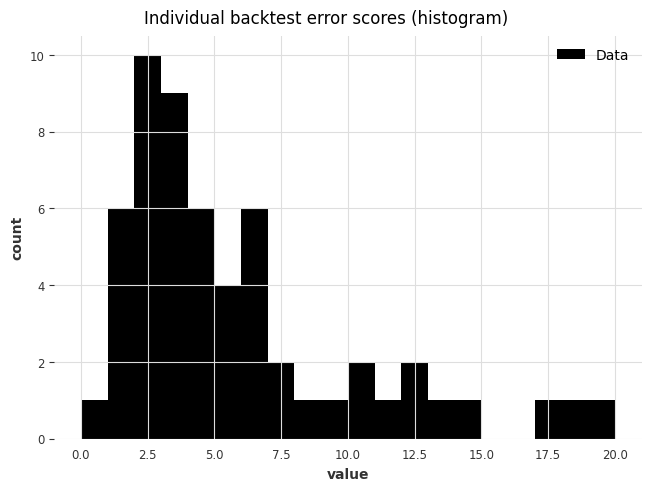

In [38]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
);

In [39]:
average_error = best_theta_model.backtest(
    metric=mape,
    reduction=np.mean,  # this is actually the default
    **hfc_params,
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}")

historical forecasts: 100%|██████████| 58/58 [00:02<00:00, 28.98it/s]

Average error (MAPE) over all historical forecasts: 6.30


In [40]:
hfc_precomputed = best_theta_model.historical_forecasts(
    last_points_only=False, stride=1, **hfc_params
)
new_error = best_theta_model.backtest(
    historical_forecasts=hfc_precomputed, last_points_only=False, stride=1, **hfc_params
)

print(f"Average error (MAPE) over all historical forecasts: {new_error:.2f}")

historical forecasts: 100%|██████████| 58/58 [00:03<00:00, 17.64it/s]


Average error (MAPE) over all historical forecasts: 6.30


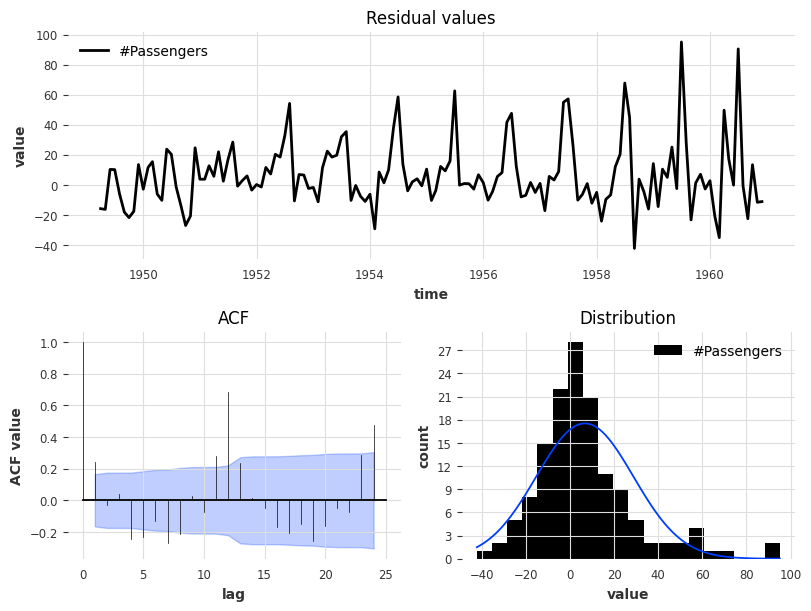

In [41]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

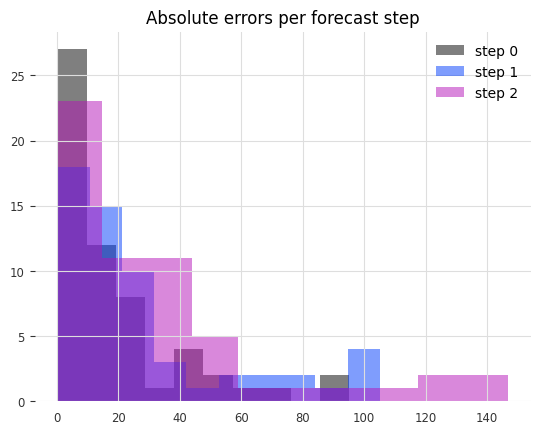

In [42]:
from darts.metrics import ae

residuals = best_theta_model.residuals(
    historical_forecasts=hfc_precomputed,
    metric=ae,  # the absolute error per time step
    last_points_only=False,
    values_only=True,  # return a list of numpy arrays
    **hfc_params,
)
residuals = np.concatenate(residuals, axis=1)[:, :, 0]

fig, ax = plt.subplots()
for forecast_step in range(len(residuals)):
    ax.hist(residuals[forecast_step], label=f"step {forecast_step}", alpha=0.5)
ax.legend()
ax.set_title("Absolute errors per forecast step");

historical forecasts: 100%|██████████| 58/58 [00:06<00:00,  8.82it/s]


MAPE = 4.42%


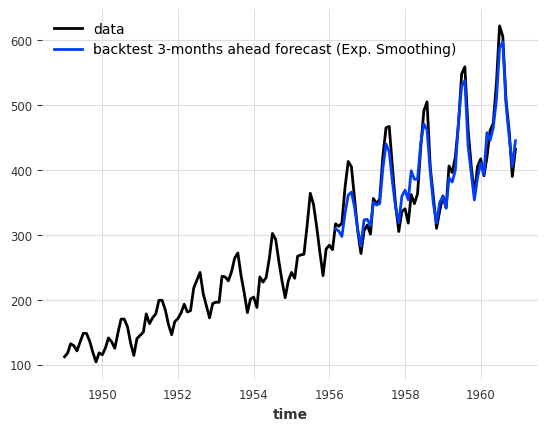

In [43]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(**hfc_params)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print(f"MAPE = {mape(historical_fcast_es, series):.2f}%")

historical forecasts: 100%|██████████| 120/120 [00:16<00:00,  7.43it/s]


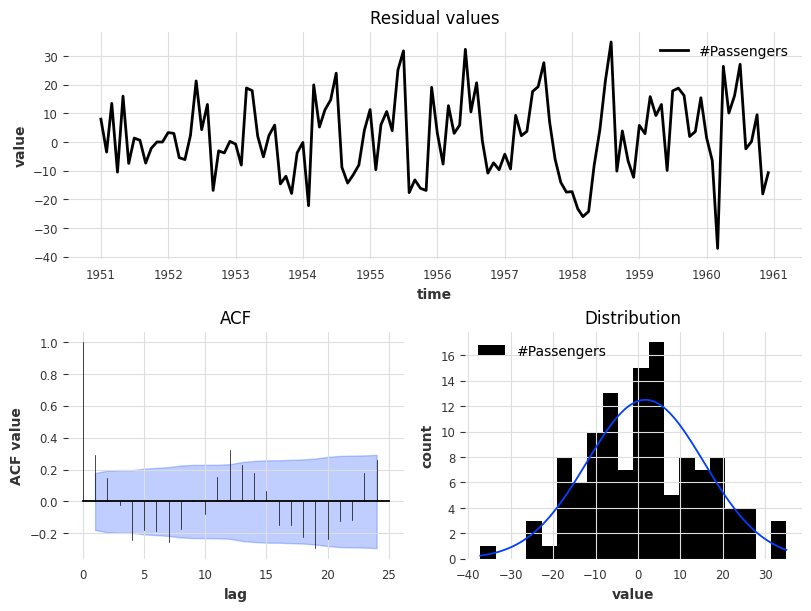

In [44]:
plot_residuals_analysis(model_es.residuals(series, verbose=True))